In [1]:
# Mute warining
import warnings
warnings.filterwarnings("ignore")

import sys
dataDir_AutoML = "/mnt/data0/Research/5_Automation/AutoML"
sys.path.append(dataDir_AutoML)

In [2]:
## =================================================================================
## ================= read csv file and extract molecular information ===============
## =================================================================================
def load_csv_file(fileNameIn, colName_mid, colName_smi, colPreCalcDesc=None, colName_expt=None, sep=','):
    import DataPrep
    import numpy as np
    import pandas as pd
    
    ## ----------- load table from csv file -----------
    dataTable_raw = pd.read_csv(fileNameIn, sep=sep).reset_index(drop=True)
    print(f"\t\tThe input file has {dataTable_raw.shape[0]} rows and {dataTable_raw.shape[1]} columns")

    ## ----------- check columns -----------
    col_list_essential = [colName_mid, colName_smi]
    if colName_expt is not None:
        col_list_essential.append(colName_expt)
    if colPreCalcDesc is not None:
        cols_custDesc = colPreCalcDesc.split(',')
        for custDesc in cols_custDesc:
            col_list_essential.append(custDesc)
    for col in col_list_essential:
        assert col in dataTable_raw.columns, print(f"\t\tError, column <{col}> is missing")

    ## ----------- extract data -----------
    mol_dict = {}
    for idx in dataTable_raw.index:
        mol_dict[idx] = {}
      
        ## ----------- molecular name/id -----------
        mid = dataTable_raw[colName_mid][idx] if dataTable_raw[colName_mid].notna()[idx] else f"Unamed_mol_row_{idx}"
        mol_dict[idx][colName_mid] = mid

        ## ----------- smiles -----------
        if dataTable_raw[colName_smi].notna()[idx]:
            smi = dataTable_raw[colName_smi][idx]
            smi_clean = DataPrep.cleanUpSmiles(smi)
            mol_dict[idx][colName_smi] = smi_clean
        else:
            mol_dict[idx][colName_smi] = np.nan

        ## ----------- expt(y) ----------- 
        if colName_expt is not None:
            if dataTable_raw[colName_expt].notna()[idx]:
                mol_dict[idx][colName_expt] = dataTable_raw[colName_expt][idx]

        ## ----------- custom desc --------------
        for col_custDesc in cols_custDesc:
            if dataTable_raw[col_custDesc].notna()[idx]:
                mol_dict[idx][f"custDesc_{col_custDesc}"] = dataTable_raw[col_custDesc][idx]
            else:
                mol_dict[idx][f"custDesc_{col_custDesc}"] = np.nan
    return mol_dict

## ======================================================================================================
## ================= determine the descriptor types/calculators needs to be calculated =================
## ======================================================================================================
def get_desc_descriptors(desc_list, desc_calc_param):
    desc_type_list, desc_calculator_list, custDesc_list = [], [], []

    ## find desc types
    for desc in desc_list:
        desc_prefix = desc.split('_')[0]
        if desc_prefix not in desc_type_list:
            desc_type_list.append(desc_prefix)
        if desc_prefix == 'custDesc':
            custDesc_list.append(desc)

    ## rdkit prop
    if 'rd' in desc_type_list:
        from DescGen import desc_calculator_rdkit
        physChem, subStr, clean = desc_calc_param['rd_physChem'], desc_calc_param['rd_subStr'], desc_calc_param['rd_clean']
        calculator_rd = desc_calculator_rdkit(physChem=physChem, subStr=subStr, clean=clean)
        desc_calculator_list.append(calculator_rd)
        
    ## mol fp
    if 'fp' in desc_type_list:
        from DescGen import desc_calculator_morganFPs
        calculator_fp = desc_calculator_morganFPs(radius=desc_calc_param['fp_radius'], nBits=desc_calc_param['fp_nBits'])
        desc_calculator_list.append(calculator_fp)

    ## chemxxon prop
    if 'cx' in desc_type_list:
        from DescGen import desc_calculator_chemaxon
        calculator_cx = desc_calculator_chemaxon(version=desc_calc_param['cx_version'], desc_list=desc_calc_param['cx_desc'])
        desc_calculator_list.append(calculator_cx)

    if 'custDesc' in desc_type_list:
        pass

    return desc_calculator_list, custDesc_list

## ==============================================================================
## =========================== preparing the descriptors ========================
## ==============================================================================
def prep_desc(mol_dict, colName_smi, desc_list, desc_calc_param, desc_norm_param, desc_impu_param):
    import numpy as np
    import pandas as pd

    ## determine the descriptor types/calculators needs to be calculated
    desc_calculator_list, custDesc_list = get_desc_descriptors(desc_list, desc_calc_param)
    
    ## ----------- calculater descriptors -----------
    for idx in mol_dict:
        smi = mol_dict[idx][colName_smi]

        ## calculated desc
        for desc_calculator in desc_calculator_list:
            desc_calculator.calculate(smi)
            desc_calc_dict = desc_calculator.dataDict_results
            for desc in desc_calc_dict:
                if desc in desc_list:
                    mol_dict[idx][desc] = desc_calc_dict[desc]

        ## custom desc 
        for custDesc in custDesc_list:
            if custDesc not in mol_dict[idx]:
                print(f"\t\tWarning! Custom descriptor <{custDesc}> is not in mol_dict for row {idx}")
                mol_dict[idx][custDesc] = np.nan
    dataTable_desc = pd.DataFrame.from_dict(mol_dict).T
    dataTable_desc_raw = pd.DataFrame.from_dict(mol_dict).T.drop(columns=[colName_smi])

    ## ----------- processing descriptors -----------
    for desc in desc_list:
        ## normalization
        assert desc in desc_norm_param, f"\t\tError! descriptor <{desc}> is not in training normalization param file"
        norm_mean, norm_std = desc_norm_param[desc]["mean"], desc_norm_param[desc]["std"]
        dataTable_desc[desc] = (dataTable_desc[desc] - norm_mean)/norm_std if norm_mean != 0 else 0

        ## imputation
        if dataTable_desc[desc].isna().sum() > 0:
            print(f"Column <{desc}> has NaN values.")
            assert desc in desc_impu_param, f"\t\tError! descriptor <{desc}> is not in imputation param file"
            with pd.option_context('future.no_silent_downcasting', True):
                impu_median = desc_impu_param[desc]["median"]
                dataTable_desc[desc] = dataTable_desc[desc].fillna(impu_median)
    return dataTable_desc, dataTable_desc_raw

## ==================

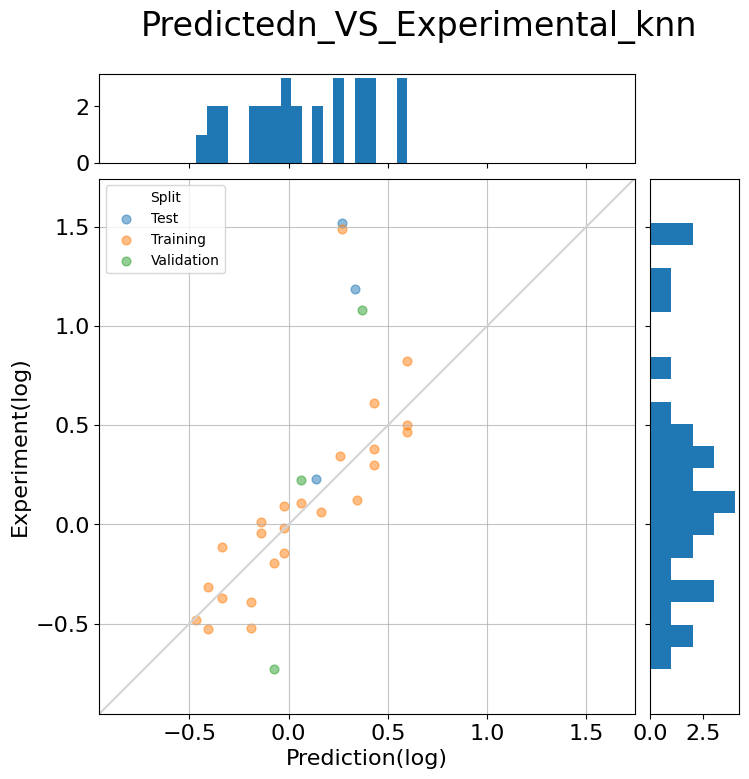

In [3]:
## ------------ load args ------------
folderPathOut = './Results'

ml_methed = 'rf'
folderPathOut_model = f"{folderPathOut}/Models"
fileNameOut_model = f"{folderPathOut_model}/{ml_methed}_models.pickle"



fileNameIn = './Data/DataView_MDCK_MDR1__Permeability_1__export_top30.csv'
sep = ','
colName_mid = 'Compound Name'
colName_smi = 'Structure'
colName_expt = 'ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)'    ## None
colPreCalcDesc = 'ADME MDCK(WT) Permeability;Mean;A to B Recovery (%),ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num)'

## ------------ load model from file ------------
import pickle
with open(fileNameOut_model, 'rb') as ifh_models:
    model_dict_load = pickle.load(ifh_models)

desc_list = model_dict_load['Desc']
ml_model = model_dict_load['model']
model_cofig = model_dict_load['config']

## ------------ load params for desc calc ------------
json_calc_param = f"{folderPathOut}/calculator_param.json"
json_norm_param = f"{folderPathOut}/feature_normalization_params.json"
json_impu_param = f"{folderPathOut}/feature_imputation_params.json"

import json
with open(json_calc_param, 'r') as ifh_dc:
    desc_calc_param = json.load(ifh_dc)
with open(json_norm_param, 'r') as ifh_dn:
    desc_norm_param = json.load(ifh_dn)
with open(json_impu_param, 'r') as ifh_di:
    desc_impu_param = json.load(ifh_di)

In [4]:
mol_dict = load_csv_file(fileNameIn, colName_mid, colName_smi, colPreCalcDesc, colName_expt, sep=',')
mol_dict

		The input file has 31 rows and 13 columns


{0: {'Compound Name': 'KT-0001674',
  'Structure': 'Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCC(=O)NC[C@@H]3CN(c4ccc(N5CCOCC5)c(F)c4)C(=O)O3)cc21',
  'ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)': np.float64(0.298012837),
  'custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%)': np.float64(65.39657381),
  'custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num)': np.float64(1.327663557)},
 1: {'Compound Name': 'KT-0001675',
  'Structure': 'Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCCNC[C@@H]3CN(c4ccc(N5CCOCC5)c(F)c4)C(=O)O3)cc21',
  'ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)': np.float64(0.767547486),
  'custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%)': np.float64(66.23493706),
  'custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num)': np.float64(8.333819159)},
 2: {'Compound Name': 'KT-0001676',
  'Structure': 'Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c(OC(C)C)cc1C1CCN(CCCCCCc2ccc3c(c2)n(C)c(=O)n3C2C

In [5]:
dataTable_desc, dataTable_desc_raw = prep_desc(mol_dict, colName_smi, desc_list, desc_calc_param, desc_norm_param, desc_impu_param)
dataTable_desc

,Compound Name,Structure,ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%),custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num),rd_MinAbsEStateIndex,rd_MinEStateIndex,rd_MaxPartialCharge,rd_MinPartialCharge,rd_FpDensityMorgan1,rd_FpDensityMorgan2,rd_FpDensityMorgan3,rd_AvgIpc,rd_BalabanJ,rd_HallKierAlpha,rd_Phi,rd_fr_Al_OH,rd_fr_Al_OH_noTert,rd_fr_Ar_N
0,KT-0001674,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCC(=O)NC[C@...,0.298013,-0.095824,-0.445915,0.695305,1.188579,0.800617,-0.016867,0.073557,0.269276,0.418144,-0.598957,0.295832,0.617892,-0.472685,-0.551677,-0.267261,-1.094541
1,KT-0001675,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCCNC[C@@H]3...,0.767547,-0.048357,1.287782,2.055788,1.21043,0.800339,-0.027695,-0.281967,-0.075789,0.219813,-0.656077,0.203643,1.030194,-0.428113,-0.551677,-0.267261,-1.094541
2,KT-0001676,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,0.186651,-2.510714,-0.761066,-0.414271,-0.605859,-0.463713,-0.978148,-0.889434,-1.039888,-0.977328,-0.861829,0.224778,0.171933,1.289382,-0.551677,-0.267261,0.099504
3,KT-0001685,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCOCC(=O)NC[C@...,0.482284,0.168017,-0.511046,0.043908,1.17598,0.800617,-0.016867,0.601109,0.736129,0.832836,-0.598957,0.295832,0.584235,-0.483404,-0.551677,-0.267261,-1.094541
4,KT-0001686,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,0.642138,-2.567982,-0.663299,-0.18538,-0.609349,-0.463713,-0.978148,-0.627053,-0.691601,-0.667955,-0.861829,0.224778,0.138275,1.277931,-0.551677,-0.267261,0.099504
5,KT-0001844,CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,15.407308,2.000106,2.559574,1.62932,1.302671,0.800617,-0.016867,2.997072,2.428471,1.691018,-3.001952,3.263657,2.612088,-2.243457,-0.551677,-0.267261,-2.288586
6,KT-0001862,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCOCCNC[C@@H]3...,0.426379,-0.315599,-0.011239,1.826896,1.197832,0.800339,-0.027695,0.257054,0.560213,0.784755,-0.656077,0.203643,0.996537,-0.439071,-0.551677,-0.267261,-1.094541
7,KT-0019184,Cn1c2ccncc2c2ccc(-c3ccc(O[C@H]4C[C@H](OC5CCN(C...,0.14,-1.695657,-0.717827,-0.050047,1.024152,-1.45977,-1.075827,-1.987287,-1.437058,-0.830783,-0.284479,-0.802204,-0.173055,-0.244079,-0.551677,-0.267261,-0.497519
8,KT-0001038,CC(=O)O[C@@H]1C[C@@H](C(=O)NCc2ccc(-n3cc(NC(=O...,0.32875,1.047898,0.132478,-1.246441,-0.270643,-0.858568,-0.397614,-0.949983,-0.923792,-0.786945,0.497503,-0.642117,-2.554309,2.376485,-0.551677,-0.267261,0.099504
9,KT-0001876,O=C1CCC(N2C[C@H](c3ccc(C#CCN4CCO[C@@H](CNC(=O)...,0.301589,1.07131,0.0832,0.373303,-0.24983,0.748084,-0.04959,-0.352747,-0.037244,0.189853,-0.278673,-0.452445,-1.721291,0.736259,-0.551677,-0.267261,0.099504


	The shape of X is (31, 16)


,Compound Name,Structure,Prediction,ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%),custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num),rd_MinAbsEStateIndex,rd_MinEStateIndex,rd_MaxPartialCharge,rd_MinPartialCharge,rd_FpDensityMorgan1,rd_FpDensityMorgan2,rd_FpDensityMorgan3,rd_AvgIpc,rd_BalabanJ,rd_HallKierAlpha,rd_Phi,rd_fr_Al_OH,rd_fr_Al_OH_noTert,rd_fr_Ar_N
0,KT-0001038,CC(=O)O[C@@H]1C[C@@H](C(=O)NCc2ccc(-n3cc(NC(=O...,0.342710,0.32875,85.597209,3.665047,0.014939,-3.035663,0.302467,-0.460573,0.897436,1.666667,2.410256,3.83405,0.689589,-8.49,17.173273,0,0,4
1,KT-0001674,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCC(=O)NC[C@...,0.394256,0.298013,65.396574,1.327664,0.132763,-0.719197,0.414317,-0.442046,1.021277,1.829787,2.595745,3.555124,0.930352,-4.72,9.568953,0,0,2
2,KT-0001675,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCCCCNC[C@@H]3...,0.460305,0.767547,66.234937,8.333819,0.215315,-0.684509,0.414298,-0.442573,0.978261,1.782609,2.565217,3.540594,0.906688,-4.23,9.687913,0,0,2
3,KT-0001676,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,0.841606,0.186651,22.744314,0.054087,0.065435,-3.567808,0.329085,-0.488822,0.904762,1.650794,2.380952,3.488253,0.912113,-5.25,14.27184,0,0,4
4,KT-0001685,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCOCC(=O)NC[C@...,0.394256,0.482284,70.056577,1.064458,0.093236,-0.739197,0.414317,-0.442046,1.085106,1.893617,2.659574,3.555124,0.930352,-4.76,9.540345,0,0,2
5,KT-0001686,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,0.841606,0.642138,21.732834,0.449181,0.079324,-3.573348,0.329085,-0.488822,0.936508,1.698413,2.428571,3.488253,0.912113,-5.29,14.241276,0,0,4
6,KT-0001844,CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,2.156288,15.407308,102.415285,13.473338,0.189438,-0.538079,0.414317,-0.442046,1.375,2.125,2.791667,2.943833,1.692165,-2.35,4.842833,0,0,0
7,KT-0001862,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCOCCNC[C@@H]3...,0.460305,0.426379,61.514861,3.084261,0.201426,-0.704509,0.414298,-0.442573,1.043478,1.869565,2.652174,3.540594,0.906688,-4.27,9.658667,0,0,2
8,KT-0001876,O=C1CCC(N2C[C@H](c3ccc(C#CCN4CCO[C@@H](CNC(=O)...,0.646527,0.301589,86.010719,3.465905,0.113224,-3.002623,0.410775,-0.443638,0.969697,1.787879,2.560606,3.636601,0.738276,-7.5,12.795576,0,0,4
9,KT-0001879,CN(CCCOCCCc1cccc2c1n(C)c(=O)n2C1CCC(=O)NC1=O)C...,1.816436,2.207218,60.159687,4.633195,0.030167,-2.928886,0.329094,-0.443638,1.047619,1.84127,2.603175,3.683598,0.767359,-6.24,13.10585,0,0,6


In [26]:
# def run_cmd(cms_list):
#     import subprocess
#     process = subprocess.Popen(cms_list, stdout=subprocess.PIPE)
#     output, error = process.communicate()
#     return (output, error)

# bash2py = "/mnt/data0/Research/0_Test/cx_pKa/bash2py_yjing_local.bash"
# scriptDir = "/mnt/data0/Research/5_Automation/AutoML"
# dataDir = "/mnt/data0/Research/5_Automation/AutoML/Data"
# resultDir = "/mnt/data0/Research/5_Automation/AutoML/results"

# script = f"{scriptDir}/DataPrep.py"
# fileIn_s1 = f"{dataDir}/DataView_MDCK_MDR1__Permeability_1__export_top30.csv"
# sep = ','

# colName_mid = "Compound Name"
# colName_smi = "Structure"
# colName_y = "ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)"
# colName_ymod = "ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Mod)"
# fileOut_s1 = f"{resultDir}/data_input_clean.csv"


# cms_list = [bash2py, "python", script, "-i", fileIn_s1, "-d", sep, "--detectEncoding", "--colId", colName_mid, "--colSmi", colName_smi, "-o", fileOut_s1]
# # ["--colAssay", colName_y, "--colAssayMod" colName_ymod]
# output, error = run_cmd(cms_list)

    